# Import Dependencies

In [331]:
import mesa
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.animation import FuncAnimation
from itertools import combinations

In [332]:
# To get rid of UserWarning regarding placing the same agent in a different position 
warnings.simplefilter("ignore", UserWarning)
# To get rid of the DeprecationWarning regarding a change in the self.schedule.agents_by_type code in the future 
warnings.simplefilter("ignore",DeprecationWarning)

# Helper Functions

In [334]:
def compute_positional_information(model):
    """
    Calculates the positional information of a system as the difference between the Shannon entropy of the 
    cell states and the conditional entropy of the cell states given cell position
    """
    # Get the Shannon entropy of the cell states
    num_both_on = 0
    num_a_on_b_off = 0
    num_a_off_b_on = 0
    num_both_off = 0
    num_of_cells = 0
    cell_states = [[cell.gene_a_activity, cell.gene_b_activity] for cell in model.schedule.agents]
    for cell_state in cell_states: 
        if cell_state[0] == "ON" and cell_state[1] == "ON":
            num_both_on += 1
            num_of_cells += 1
        elif cell_state[0] == "ON" and cell_state[1] == "OFF":
            num_a_on_b_off += 1
            num_of_cells += 1
        elif cell_state[0] == "OFF" and cell_state[1] == "ON":
            num_a_off_b_on += 1
            num_of_cells += 1
        elif cell_state[0] == "OFF" and cell_state[1] == "OFF":
            num_both_off += 1
            num_of_cells += 1
    # Calculate the probabilities of attaining each cell state 
    if num_of_cells != 0: 
        probability_both_on = num_both_on/num_of_cells
        probability_a_on_b_off = num_a_on_b_off/num_of_cells
        probability_a_off_b_on = num_a_off_b_on/num_of_cells
        probability_both_off = num_both_off/num_of_cells
    else: 
        probability_both_on = 0
        probability_a_on_b_off = 0
        probability_a_off_b_on = 0
        probability_both_off = 0
    # Account for the ValueError: math domain error due to zero not being in the domain of log2
    list_of_probabilities = [probability_both_on, probability_a_on_b_off, probability_a_off_b_on, probability_both_off]
    shannon_entropy = 0
    for probability in list_of_probabilities: 
        if probability != 0: 
            shannon_entropy -= probability * math.log2(probability)
    
    # Get the conditional entropy of the cell states given cell position (always zero in this case) 
    conditional_entropy = 0

    # Calculate the positional information in the system 
    positional_information = shannon_entropy - conditional_entropy 
    return positional_information 


# Agent Class

In [336]:
class Cell(mesa.Agent):
    def __init__(self, unique_id, model, pos, gene_a_activity, gene_b_activity, color):
        """
        Initializer function for cells' id, position, and gene expression
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.gene_a_activity = gene_a_activity 
        self.gene_b_activity = gene_b_activity 
        self.color = color

    def maybe_mitosis(self, pos):
        """
        Helper function called in step function of the model class to help a parent cell divide into two identical daughter 
        cells. Function returns a list containing the cell's cell state and the positions of the two daughter cells  
        """
        # Both daughter cells inherit the gene activity of their parent cell 
        daughter_gene_a_activity = self.gene_a_activity
        daughter_gene_b_activity = self.gene_b_activity
        daughter_color = self.color
        daughter_gene_activity = [daughter_gene_a_activity, daughter_gene_b_activity]
        # One daughter cell inherits the position of its parent cell 
        daughter_one_pos = self.pos
        # The second daughter cell takes a position either to the left or right of its sister unless there is empty space
        (x,y) = self.pos
        left_neighbor_pos = (x-1,y)
        right_neighbor_pos = (x+1,y)
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        
        # See if there is empty space to the left or right of the sister cell 
        left_neighbor_presence = False
        right_neighbor_presence = False 
        for neighbor in neighbors: 
            if isinstance(neighbor, Cell):
                if neighbor.pos == left_neighbor_pos:
                    left_neighbor_presence = True 
                elif neighbor.pos == right_neighbor_pos: 
                    right_neighbor_presence = True
                    
        # Determine the second daughter cell's position depending on the presence of neighboring cells    
        if left_neighbor_presence == True and right_neighbor_presence == True: 
            if random.randint(0,1) == 0: 
                daughter_two_pos = right_neighbor_pos
            else: 
                daughter_two_pos = left_neighbor_pos
        elif left_neighbor_presence == False and right_neighbor_presence == False: 
            if random.randint(0,1) == 0: 
                daughter_two_pos = right_neighbor_pos
            else: 
                daughter_two_pos = left_neighbor_pos
        elif left_neighbor_presence == True and right_neighbor_presence == False: 
            daughter_two_pos = right_neighbor_pos
        elif left_neighbor_presence == False and right_neighbor_presence == True:
            daughter_two_pos = left_neighbor_pos

        # Determine whether to shift the other existing cells to the left or right 
        if daughter_two_pos == left_neighbor_pos and left_neighbor_presence == True: 
            shift = "left"
        elif daughter_two_pos == right_neighbor_pos and right_neighbor_presence == True: 
            shift = "right"
        else: 
            shift = "no shift"
        # Store the information in a list 
        new_cell_info = [daughter_gene_activity, daughter_one_pos, daughter_two_pos, shift, daughter_color]
        return new_cell_info

    def determine_gene_activity(self, pos, gene_activities, list_of_actions):
        """
        Helper function called in step function of the model class which determines whether genes A and B are ON or OFF
        """
        # Determine if other cells exist to the left and right of the cell and retrieve their gene activities if so 
        neighboring_gene_a_activities = []
        neighboring_gene_b_activities = []
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        for neighbor in neighbors:
            if isinstance(neighbor, Cell):
                neighbor_gene_activity = gene_activities.get(neighbor.pos)
                neighbor_gene_a_activity = neighbor_gene_activity[0]
                neighbor_gene_b_activity = neighbor_gene_activity[1]
                    
                if neighbor_gene_a_activity == "ON": 
                    neighboring_gene_a_activities.append(1)
                elif neighbor_gene_a_activity == "OFF":
                    neighboring_gene_a_activities.append(0)
                if neighbor_gene_b_activity == "ON": 
                    neighboring_gene_b_activities.append(1)
                elif neighbor_gene_b_activity == "OFF":    
                    neighboring_gene_b_activities.append(0)

        # All possible intracellular actions are initially assumed to have no weight 
        gene_a_on_gene_a_intracellular_activation = 0
        gene_a_on_gene_a_intracellular_inhibition = 0
        gene_a_on_gene_b_intracellular_activation = 0
        gene_a_on_gene_b_intracellular_inhibition = 0
        gene_b_on_gene_b_intracellular_activation = 0
        gene_b_on_gene_b_intracellular_inhibition = 0
        gene_b_on_gene_a_intracellular_activation = 0
        gene_b_on_gene_a_intracellular_inhibition = 0
        # Determine whether each possible intracellular action should be weighed 
        if 1 in list_of_actions:
            # Determine the weight of the intracellular activation of gene A on gene A
            if self.gene_a_activity == "ON":
                gene_a_on_gene_a_intracellular_activation = 1*1
            elif self.gene_a_activity == "OFF":
                gene_a_on_gene_a_intracellular_activation = 1*0
        if 2 in list_of_actions: 
            # Determine the weight of the intracellular inhibition of gene A on gene A
            if self.gene_a_activity == "ON":
                gene_a_on_gene_a_intracellular_inhibition = -1*1
            elif self.gene_a_activity == "OFF":
                gene_a_on_gene_a_intracellular_inhibition = -1*0
        if 3 in list_of_actions: 
            # Determine the weight of the intracellular activation of gene A on gene B
            if self.gene_a_activity == "ON":
                gene_a_on_gene_b_intracellular_activation = 1*1
            elif self.gene_a_activity == "OFF":
                gene_a_on_gene_b_intracellular_activation = 1*0
        if 4 in list_of_actions: 
            # Determine the weight of the intracellular inhibition of gene A on gene B
            if self.gene_a_activity == "ON":
                gene_a_on_gene_b_intracellular_inhibition = -1*1
            elif self.gene_a_activity == "OFF":
                gene_a_on_gene_b_intracellular_inhibition = -1*0
        if 5 in list_of_actions: 
            # Determine the weight of the intracellular activation of gene B on gene B
            if self.gene_b_activity == "ON":
                gene_b_on_gene_b_intracellular_activation = 1*1
            elif self.gene_b_activity == "OFF":
                gene_b_on_gene_b_intracellular_activation = 1*0
        if 6 in list_of_actions: 
            # Determine the weight of the intracellular inhibition of gene B on gene B
            if self.gene_b_activity == "ON":
                gene_b_on_gene_b_intracellular_inhibition = -1*1
            elif self.gene_b_activity == "OFF":
                gene_b_on_gene_b_intracellular_inhibition = -1*0
        if 7 in list_of_actions: 
            # Determine the weight of the intracellular activation of gene B on gene A
            if self.gene_b_activity == "ON":
                gene_b_on_gene_a_intracellular_activation = 1*1
            elif self.gene_b_activity == "OFF":
                gene_b_on_gene_a_intracellular_activation = 1*0
        if 8 in list_of_actions: 
            # Determine the weight of the intracellular inhibition of gene B on gene A
            if self.gene_b_activity == "ON":
                gene_b_on_gene_a_intracellular_inhibition = -1*1
            elif self.gene_b_activity == "OFF":
                gene_b_on_gene_a_intracellular_inhibition = -1*0

        # All possible intercellular actions are initially assumed to have no weight 
        gene_a_on_gene_a_intercellular_activation = 0
        gene_a_on_gene_a_intercellular_inhibition = 0
        gene_a_on_gene_b_intercellular_activation = 0
        gene_a_on_gene_b_intercellular_inhibition = 0
        gene_b_on_gene_b_intercellular_activation = 0
        gene_b_on_gene_b_intercellular_inhibition = 0
        gene_b_on_gene_a_intercellular_activation = 0
        gene_b_on_gene_a_intercellular_inhibition = 0
        # Determine whether each possible intercellular action should be weighed 
        if 9 in list_of_actions:
            # Determine the weight of the intercellular activation of adjacent gene A's on gene A
            for gene_a_activity in neighboring_gene_a_activities:
                gene_a_on_gene_a_intercellular_activation += gene_a_activity 
        if 10 in list_of_actions: 
            # Determine the weight of the intercellular inhibition of adjacent gene A's on gene A
            for gene_a_activity in neighboring_gene_a_activities:
                gene_a_on_gene_a_intercellular_inhibition -= gene_a_activity 
        if 11 in list_of_actions:
            # Determine the weight of the intercellular activation of adjacent gene A's on gene B
            for gene_a_activity in neighboring_gene_a_activities:
                gene_a_on_gene_b_intercellular_activation += gene_a_activity 
        if 12 in list_of_actions: 
            # Determine the weight of the intercellular inhibition of adjacent gene A's on gene B
            for gene_a_activity in neighboring_gene_a_activities:
                gene_a_on_gene_b_intercellular_inhibition -= gene_a_activity 
        if 13 in list_of_actions:
            # Determine the weight of the intercellular activation of adjacent gene B's on gene B
            for gene_b_activity in neighboring_gene_b_activities:
                gene_b_on_gene_b_intercellular_activation += gene_b_activity 
        if 14 in list_of_actions: 
            # Determine the weight of the intercellular inhibition of adjacent gene B's on gene B
            for gene_b_activity in neighboring_gene_b_activities:
                gene_b_on_gene_b_intercellular_inhibition -= gene_b_activity 
        if 15 in list_of_actions:
            # Determine the weight of the intercellular activation of adjacent gene B's on gene A
            for gene_b_activity in neighboring_gene_b_activities:
                gene_b_on_gene_a_intercellular_activation += gene_b_activity 
        if 16 in list_of_actions: 
            # Determine the weight of the intercellular inhibition of adjacent gene B's on gene A
            for gene_b_activity in neighboring_gene_b_activities:
                gene_b_on_gene_a_intercellular_inhibition -= gene_b_activity

        # Determine the new gene A activity of the cell after the effects of the genetic network 
        gene_a_genetic_network_effects = (gene_a_on_gene_a_intracellular_activation + gene_a_on_gene_a_intracellular_inhibition + 
                                          gene_b_on_gene_a_intracellular_activation + gene_b_on_gene_a_intracellular_inhibition +
                                          gene_a_on_gene_a_intercellular_activation + gene_a_on_gene_a_intercellular_inhibition + 
                                          gene_b_on_gene_a_intercellular_activation + gene_b_on_gene_a_intercellular_inhibition)
        if gene_a_genetic_network_effects > 0:
            new_gene_a_activity = "ON"
        elif gene_a_genetic_network_effects < 0: 
            new_gene_a_activity = "OFF"
        elif gene_a_genetic_network_effects == 0:
            new_gene_a_activity = self.gene_a_activity
        self.gene_a_activity = new_gene_a_activity

        # Determine the new gene B activity of the cell after the effects of the genetic network 
        gene_b_genetic_network_effects = (gene_b_on_gene_b_intracellular_activation + gene_b_on_gene_b_intracellular_inhibition +
                                          gene_a_on_gene_b_intracellular_activation + gene_a_on_gene_b_intracellular_inhibition +
                                          gene_b_on_gene_b_intercellular_activation + gene_b_on_gene_b_intercellular_inhibition +
                                          gene_a_on_gene_b_intercellular_activation + gene_a_on_gene_b_intercellular_inhibition)
        if gene_b_genetic_network_effects > 0:
            new_gene_b_activity = "ON"
        elif gene_b_genetic_network_effects < 0: 
            new_gene_b_activity = "OFF"
        elif gene_b_genetic_network_effects == 0:
            new_gene_b_activity = self.gene_b_activity
        self.gene_b_activity = new_gene_b_activity

        # Determine the new corresponding color of the cell 
        if self.gene_a_activity == "ON" and self.gene_b_activity == "ON":
            self.color = "blue"
        elif self.gene_a_activity == "ON" and self.gene_b_activity == "OFF":
            self.color = "green"
        elif self.gene_a_activity == "OFF" and self.gene_b_activity == "ON":
            self.color = "red"
        elif self.gene_a_activity == "OFF" and self.gene_b_activity == "OFF":
            self.color = "yellow"
        
    def maybe_die(self):
        """
        Helper function called in step function of model class which determines if a cell dies and conducts the death if so 
        """
        # State of (0,0) is arbitrarily chosen to be the state where cells die
        if self.gene_a_activity == "OFF" and self.gene_b_activity == "OFF": 
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    def maybe_shift(self, center_pos):
        """
        Helper function called in step function of model class which determines if a cell has to shift to fill in empty space created by 
        cells that died
        """
        # Shift the cells toward the center of the grid if there is empty space 
        (x,y) = self.pos
        (center_x,center_y) = center_pos
        if x <= center_x: 
            while x < center_x:
                x += 1
                cell_to_right = (x,y)
                while self.model.grid.is_cell_empty(cell_to_right) == True:
                    self.model.grid.move_agent(self, cell_to_right)
                
        elif x > center_x: 
            while x > center_x:
                x -= 1
                cell_to_left = (x,y)
                while self.model.grid.is_cell_empty(cell_to_left) == True: 
                    self.model.grid.move_agent(self, cell_to_left)
                    
        

# Model Class

In [338]:
class Cell_Model(mesa.Model):
    def __init__(self, width, height, list_of_actions, max_steps):
        """
        Initializer function which creates the initial cell and adds it to the grid and scheduler 
        """
        super().__init__() 
        self.width = width
        self.height = height
        self.list_of_actions = list_of_actions 
        self.step_count = 0
        self.id_count = 1
        self.max_steps = max_steps
        self.running = True
        
        # Initialize scheduler
        self.schedule = mesa.time.RandomActivationByType(self)
        # Initialize grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
        # Initialize data collector which tracks the positional information in the system  
        self.datacollector = mesa.DataCollector(model_reporters={"Positional Information": compute_positional_information})
    
        # Create initial cell and add it to the scheduler and grid        
        x = int(self.width/2)
        y = int(self.height/2)
        unique_id = self.id_count
        # Gene activities and corresponding color may need to be defined in other models
        gene_a_activity = "ON"
        gene_b_activity = "OFF"
        if gene_a_activity == "ON" and gene_b_activity == "ON":
            color = "blue"
        elif gene_a_activity == "ON" and gene_b_activity == "OFF":
            color = "green"
        elif gene_a_activity == "OFF" and gene_b_activity == "ON":
            color = "red"
        elif gene_a_activity == "OFF" and gene_b_activity == "OFF":
            color = "yellow"
        new_cell = Cell(unique_id, self, (x,y), gene_a_activity, gene_b_activity, color)
        self.grid.place_agent(new_cell, (x,y))
        self.schedule.add(new_cell)
        self.id_count += 1

    def recall_cell_states(self):
        """
        Helper function called in step function of the model class which stores information on all the cell states 
        in the system before any of the cells have undergone changes in gene activity 
        """
        # Create dictionary where the key is the cell's position and the value is the cell's gene activity 
        gene_activities = {}
        for cell in self.schedule.agents:
            gene_activities[cell.pos] = [cell.gene_a_activity, cell.gene_b_activity]
        return gene_activities 

    def determine_shifting_cells(self, mother_cell_pos, shift):
        """
        Helper function called in step function of the model class which determines which cells will have to shift 
        outward to make room for a daughter cell 
        """
        cell_ids_and_positions = {}
        cells_to_shift = {}
        (x1,y1) = mother_cell_pos 
        # Get the position of every cell in the system 
        for cell in self.schedule.agents:
            (x,y) = cell.pos
            unique_id = cell.unique_id
            cell_ids_and_positions[x] = unique_id 
        
        # Determine the ids and positions of the cells which need to shift
        if shift == "left":
            for x, unique_id in cell_ids_and_positions.items():
                if x < x1: 
                    cells_to_shift[x] = unique_id
            cells_to_shift = dict(sorted(cells_to_shift.items()))  
        elif shift == "right":
            for x, unique_id in cell_ids_and_positions.items():
                if x > x1: 
                    cells_to_shift[x] = unique_id
            cells_to_shift = dict(sorted(cells_to_shift.items(), reverse=True))
        return cells_to_shift

    def center_cells(self, center_pos):
        """
        Helper function used in the step function of the model class which shifts the cells to the center of the grid to help the
        visualization tool 
        """
        list_of_pos = []
        need_to_recenter = False 
        # Get all the cell positions  
        for cell in self.schedule.agents: 
            list_of_pos.append(cell.pos)
        # Determine which cell should be at the center (given an even number of cells, it is the cell in the center on the right)
        sorted_list_of_pos = sorted(list_of_pos, key=lambda x: x[0])
        if len(sorted_list_of_pos) > 1: 
            center_index = int((len(sorted_list_of_pos))/2)
            # Determine if the cells are centered 
            if sorted_list_of_pos[center_index] != center_pos: 
                need_to_recenter = True
                distance_to_shift = center_pos[0] - sorted_list_of_pos[center_index][0]
        
        # Shift the cells if needed, starting with the leftmost cell  
        if need_to_recenter == True:
            for cell in self.schedule.agents:
                (x,y) = cell.pos
                new_pos = (x+distance_to_shift,y)
                self.grid.move_agent(cell, new_pos)
                cell.pos = new_pos
            
    def step(self):
        """
        Step function that advances the model by one unit of time
        """
        if self.step_count > self.max_steps:
            self.running = False
        else:
            # Calculate the positional information of the step 
            self.datacollector.collect(self)
            # Have each cell reevaluate their gene activity 
            gene_activities = self.recall_cell_states()
            for cell in self.schedule.agents:
                cell.determine_gene_activity(cell.pos, gene_activities, self.list_of_actions)

            # Have each cell die if their cell state is not stable
            for cell in self.schedule.agents: 
                cell.maybe_die()

            # Have each cell undergo mitosis if a cell generation (four steps) has elapsed
            for cell in self.schedule.agents: 
                if self.step_count%4 == 0 and self.step_count > 0: 
                    # Collect all the information needed to conduct mitosis
                    new_cell_info = cell.maybe_mitosis(cell.pos)
                    daughter_gene_a_activity = new_cell_info[0][0]
                    daughter_gene_b_activity = new_cell_info[0][1]
                    daughter_one_pos = new_cell_info[1]
                    daughter_two_pos = new_cell_info[2]
                    shift = new_cell_info[3]
                    daughter_color = new_cell_info[4]
                    cells_to_shift = self.determine_shifting_cells(cell.pos, shift)
                    # Remove the parent cell 
                    self.grid.remove_agent(cell)
                    self.schedule.remove(cell)
                
                    # Shift the existing cells on one side to make room for the daughter cells 
                    for target_id in cells_to_shift.values():
                        for cell in self.schedule.agents:
                            if cell.unique_id == target_id and shift == "left": 
                                (x,y) = cell.pos
                                new_pos = (x-1,y)
                                self.grid.move_agent(cell, new_pos)
                                cell.pos = new_pos
                            elif cell.unique_id == target_id and shift == "right":
                                (x,y) = cell.pos
                                new_pos = (x+1,y)
                                self.grid.move_agent(cell, new_pos)
                                cell.pos = new_pos

                    # Create the daughter cells and add them to the grid and scheduler 
                    unique_id_one = self.id_count
                    daughter_one = Cell(unique_id_one, self, daughter_one_pos, gene_a_activity=daughter_gene_a_activity,
                                       gene_b_activity=daughter_gene_b_activity, color=daughter_color)
                    self.grid.place_agent(daughter_one, daughter_one_pos)
                    self.schedule.add(daughter_one)
                    self.id_count += 1
                    unique_id_two = self.id_count 
                    daughter_two = Cell(unique_id_two, self, daughter_two_pos, gene_a_activity=daughter_gene_a_activity,
                                       gene_b_activity=daughter_gene_b_activity, color=daughter_color)
                    self.grid.place_agent(daughter_two, daughter_two_pos)
                    self.schedule.add(daughter_two)
                    self.id_count += 1

            # Have cells shift to fill in the gaps created by dead cells 
            center_x = int(self.width/2)
            center_y = int(self.height/2)
            center_pos = (center_x,center_y)
            for cell in self.schedule.agents:
                cell.maybe_shift(center_pos)

            # Center the cells if necessary for the visualization tool 
            self.center_cells(center_pos)
            
            # Note that a step has passed 
            self.step_count += 1
            
    def get_cell_positions_and_states(self):
        """
        Helper function used in the visualization tool that returns a list of tuples containing the 
        position and color of every cell in the model 
        """
        cell_positions_and_states = []
        for cell in self.schedule.agents:
            cell_positions_and_states.append((cell.pos, cell.color))
        return cell_positions_and_states
       

# Running the Model 

In [340]:
def run_model(max_steps, actions):
    width = 2**(1+(max_steps//4))
    height = 1
    model = Cell_Model(width, height, actions, max_steps)
    for i in range(max_steps):
        model.step()   
    return model.datacollector.get_model_vars_dataframe()


In [341]:
results1 = run_model(18, [1,4,11,16])
print(results1)


    Positional Information
0                      0.0
1                      0.0
2                      0.0
3                      0.0
4                      0.0
5                      0.0
6                      0.0
7                      0.0
8                      0.0
9                      0.0
10                     1.0
11                     1.0
12                     1.0
13                     1.0
14                     1.5
15                     1.5
16                     1.5
17                     1.5


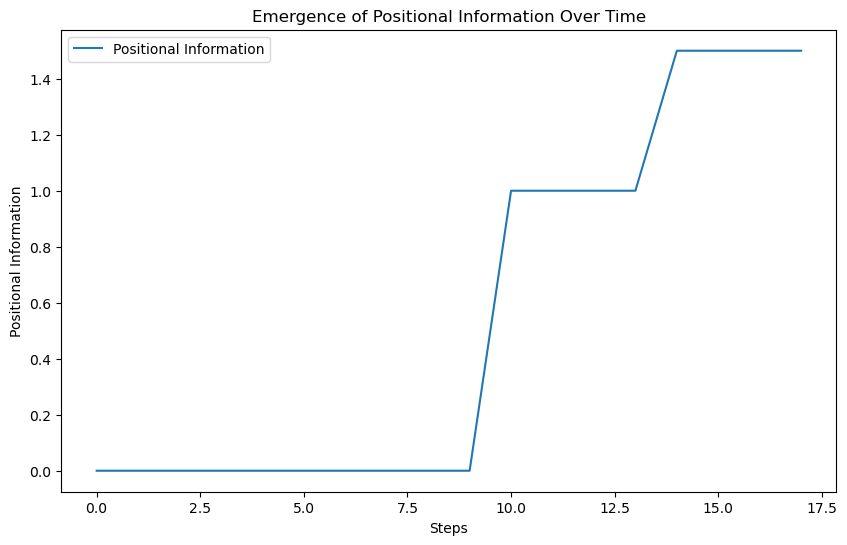

In [342]:
plt.figure(figsize=(10, 6))
plt.plot(results1["Positional Information"], label="Positional Information")
plt.xlabel("Steps")
plt.ylabel("Positional Information")
plt.title("Emergence of Positional Information Over Time")
plt.legend()
plt.show()

# Batch Runner

In [344]:
all_combinations_of_actions = []
list_of_possible_actions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for r in range(1, len(list_of_possible_actions) + 1):
    all_combinations_of_actions.extend(list(combinations(list_of_possible_actions, r)))

# Account for the fact that you cannot have an activation and inhibition of the same gene by the same gene(s)
# Network where there are no actions at all is not considered/believed to be trivial 
all_combinations_of_actions = [list(combo) for combo in all_combinations_of_actions]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (1 in combo and 2 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (3 in combo and 4 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (5 in combo and 6 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (7 in combo and 8 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (9 in combo and 10 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (11 in combo and 12 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (13 in combo and 14 in combo)]
all_combinations_of_actions = [combo for combo in all_combinations_of_actions if not (15 in combo and 16 in combo)]

print(len(all_combinations_of_actions))

6560


In [345]:
# This will run all genetic networks and return a list of genetic networks which yield positional information greater than 1
list_of_high_positional_information_genetic_networks = []
for combination_of_actions in all_combinations_of_actions: 
    results = run_model(15, combination_of_actions)
    filtered_results = results[results["Positional Information"] >= 1]
    if filtered_results.empty:
        pass
    else: 
        list_of_high_positional_information_genetic_networks.append(combination_of_actions)

print(list_of_high_positional_information_genetic_networks)

[[3, 12], [3, 14], [4, 11], [1, 3, 10], [1, 3, 12], [1, 3, 14], [1, 3, 16], [1, 4, 11], [1, 10, 11], [1, 11, 16], [3, 7, 10], [3, 7, 12], [3, 7, 14], [3, 7, 16], [3, 8, 15], [3, 9, 12], [3, 9, 14], [3, 12, 15], [3, 14, 15], [4, 5, 11], [4, 6, 11], [4, 7, 11], [4, 8, 11], [4, 9, 11], [4, 11, 13], [4, 11, 14], [4, 11, 15], [4, 11, 16], [7, 10, 11], [7, 11, 16], [1, 3, 5, 10], [1, 3, 5, 16], [1, 3, 6, 10], [1, 3, 6, 16], [1, 3, 7, 12], [1, 3, 7, 14], [1, 3, 8, 12], [1, 3, 8, 14], [1, 3, 9, 12], [1, 3, 9, 14], [1, 3, 10, 11], [1, 3, 10, 13], [1, 3, 11, 16], [1, 3, 12, 15], [1, 3, 13, 16], [1, 3, 14, 15], [1, 4, 5, 11], [1, 4, 6, 11], [1, 4, 7, 11], [1, 4, 8, 11], [1, 4, 9, 11], [1, 4, 10, 11], [1, 4, 11, 13], [1, 4, 11, 14], [1, 4, 11, 15], [1, 4, 11, 16], [1, 5, 10, 11], [1, 5, 11, 16], [1, 6, 10, 11], [1, 6, 11, 16], [1, 10, 11, 13], [1, 10, 11, 14], [1, 11, 13, 16], [1, 11, 14, 16], [2, 3, 7, 12], [2, 3, 7, 14], [2, 3, 8, 15], [2, 3, 12, 15], [3, 5, 7, 10], [3, 5, 7, 16], [3, 5, 8, 15],

In [346]:
# This will run all genetic networks and return a list of genetic networks which yield positional information greater than 1.5
list_of_high_positional_information_genetic_networks2 = []
for combination_of_actions in all_combinations_of_actions: 
    results = run_model(15, combination_of_actions)
    filtered_results = results[results["Positional Information"] >= 1.5]
    if filtered_results.empty:
        pass
    else: 
        list_of_high_positional_information_genetic_networks2.append(combination_of_actions)
print(list_of_high_positional_information_genetic_networks2)

[[1, 4, 11, 16], [1, 3, 10, 14, 15], [1, 4, 5, 11, 16], [1, 4, 6, 11, 16], [1, 4, 7, 10, 11], [1, 4, 10, 11, 13], [1, 4, 10, 11, 15], [2, 3, 7, 14, 15], [3, 5, 8, 14, 15], [3, 6, 7, 10, 11], [4, 8, 9, 11, 16], [5, 7, 10, 11, 14], [1, 3, 7, 10, 14, 15], [1, 4, 5, 7, 10, 11], [1, 4, 5, 10, 11, 13], [1, 4, 5, 10, 11, 15], [1, 4, 5, 11, 14, 16], [1, 4, 6, 10, 11, 13], [1, 4, 6, 11, 13, 16], [1, 4, 7, 10, 11, 13], [1, 4, 8, 10, 11, 13], [1, 4, 8, 10, 11, 15], [1, 4, 10, 11, 13, 15], [3, 5, 7, 10, 11, 14], [3, 5, 8, 9, 14, 15], [4, 5, 8, 9, 11, 16], [4, 6, 8, 9, 11, 16], [1, 4, 5, 7, 10, 11, 13], [1, 4, 5, 8, 10, 11, 13], [1, 4, 5, 8, 10, 11, 15], [1, 4, 5, 10, 11, 13, 15], [1, 4, 6, 7, 10, 11, 13], [1, 4, 6, 8, 10, 11, 13], [1, 4, 6, 10, 11, 13, 15], [1, 4, 8, 10, 11, 13, 15], [2, 3, 5, 8, 9, 14, 15], [4, 5, 8, 9, 11, 14, 16], [1, 4, 5, 8, 10, 11, 13, 15], [1, 4, 6, 8, 10, 11, 13, 15]]


In [347]:
# This will run all genetic networks and return a list of genetic networks which yield positional information greater than 0
list_of_high_positional_information_genetic_networks3 = []
for combination_of_actions in all_combinations_of_actions: 
    results = run_model(15, combination_of_actions)
    filtered_results = results[results["Positional Information"] > 0]
    if filtered_results.empty:
        pass
    else: 
        list_of_high_positional_information_genetic_networks3.append(combination_of_actions)
print(list_of_high_positional_information_genetic_networks3)

[[3, 12], [3, 14], [4, 11], [1, 3, 10], [1, 3, 12], [1, 3, 14], [1, 3, 16], [1, 4, 11], [1, 10, 11], [1, 11, 16], [3, 7, 10], [3, 7, 12], [3, 7, 14], [3, 7, 16], [3, 8, 15], [3, 9, 12], [3, 9, 14], [3, 12, 15], [3, 14, 15], [4, 5, 11], [4, 6, 11], [4, 7, 11], [4, 8, 11], [4, 9, 11], [4, 11, 13], [4, 11, 14], [4, 11, 15], [4, 11, 16], [7, 10, 11], [7, 11, 16], [1, 3, 5, 10], [1, 3, 5, 16], [1, 3, 6, 10], [1, 3, 6, 16], [1, 3, 7, 12], [1, 3, 7, 14], [1, 3, 8, 12], [1, 3, 8, 14], [1, 3, 9, 12], [1, 3, 9, 14], [1, 3, 10, 11], [1, 3, 10, 13], [1, 3, 11, 16], [1, 3, 12, 15], [1, 3, 13, 16], [1, 3, 14, 15], [1, 4, 5, 11], [1, 4, 6, 11], [1, 4, 7, 11], [1, 4, 8, 11], [1, 4, 9, 11], [1, 4, 10, 11], [1, 4, 11, 13], [1, 4, 11, 14], [1, 4, 11, 15], [1, 4, 11, 16], [1, 5, 10, 11], [1, 5, 11, 16], [1, 6, 10, 11], [1, 6, 11, 16], [1, 10, 11, 13], [1, 10, 11, 14], [1, 11, 13, 16], [1, 11, 14, 16], [2, 3, 7, 12], [2, 3, 7, 14], [2, 3, 8, 15], [2, 3, 12, 15], [3, 5, 7, 10], [3, 5, 7, 16], [3, 5, 8, 15],

In [348]:
# This will run all genetic networks and return a list of genetic networks which yield positional information greater than 2
list_of_high_positional_information_genetic_networks4 = []
for combination_of_actions in all_combinations_of_actions: 
    results = run_model(15, combination_of_actions)
    filtered_results = results[results["Positional Information"] >= 2]
    if filtered_results.empty:
        pass
    else: 
        list_of_high_positional_information_genetic_networks4.append(combination_of_actions)
print(list_of_high_positional_information_genetic_networks4)

[]


In [349]:
print(len(list_of_high_positional_information_genetic_networks))
print(len(list_of_high_positional_information_genetic_networks2))
print(len(list_of_high_positional_information_genetic_networks3))
print(len(list_of_high_positional_information_genetic_networks4))
print(len(all_combinations_of_actions))

773
39
773
0
6560


# Visualization Tool

In [351]:
def run_model_with_viz(max_steps, actions):
    width = 2**(1+(max_steps//4))
    height = 1  
    model = Cell_Model(width, height, actions, max_steps)
    list_of_pos_and_plot_colors = []
    # Run the model and capture all the data for the visualization 
    amount_to_add_to_y = -0.1
    for i in range(max_steps):
        model.step()   
        cell_positions_and_states = model.get_cell_positions_and_states()
        positions, colors = zip(*cell_positions_and_states)
        x,y = zip(*positions)
        # Change the y values to graph the cell states one on top of another 
        new_y = tuple(y_value + amount_to_add_to_y for y_value in y)
        list_of_colors = []
        for color in colors:
            list_of_colors.append(color)
        plot_colors = np.array(list_of_colors)
        list_of_pos_and_plot_colors.append([x,new_y,plot_colors])
        amount_to_add_to_y -= 0.1

    # Create scatterplot visualizing the cell states in the model
    fig, ax = plt.subplots()
    for i, pos_and_plot_colors in enumerate(list_of_pos_and_plot_colors):
        x = pos_and_plot_colors[0]
        y = pos_and_plot_colors[1]
        plot_colors = pos_and_plot_colors[2]
        # Center the x values of the first cell 
        if i < 4: 
            x = tuple(x_value - 0.5 for x_value in x)    
        ax.set_xlim(0, model.grid.width)
        ax.set_ylim(-4, model.grid.height)
        ax.scatter(x, y, s=18, c=plot_colors)
    plt.title("Cell States in ABM")
    plt.axis("off")
    plt.xlabel("X-Coordinate")
    plt.ylabel("Y-Coordinate")
    plt.show() 
    return model.datacollector.get_model_vars_dataframe()


In [352]:
def run_model_with_viz_every_step(max_steps, actions):
    width = 2**(1+(max_steps//4))
    height = 1  
    model = Cell_Model(width, height, actions, max_steps)
    for i in range(max_steps):
        model.step()   
        cell_positions_and_states = model.get_cell_positions_and_states()
        positions, colors = zip(*cell_positions_and_states)
        x,y = zip(*positions)
        print(x)
        list_of_colors = []
        for color in colors:
            list_of_colors.append(color)
        plot_colors = np.array(list_of_colors)
        # Create scatterplot visualizing the cell states in the model 
        fig, ax = plt.subplots()
        ax.set_xlim(0, model.grid.width)
        ax.set_ylim(-1, model.grid.height)
        ax.scatter(x, y, s=17, c=plot_colors)
        plt.title("Cell States in ABM")
        plt.xlabel("X-Coordinate")
        plt.ylabel("Y-Coordinate")
        plt.show()  
    return model.datacollector.get_model_vars_dataframe()


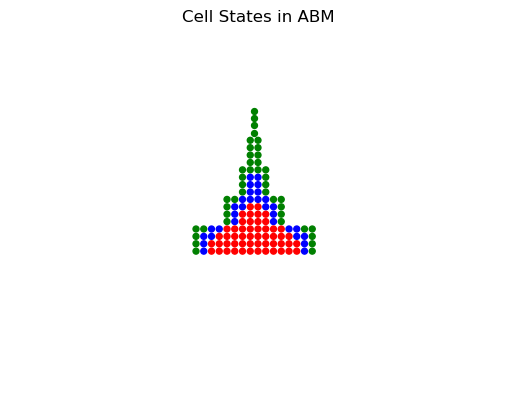

    Positional Information
0                 0.000000
1                 0.000000
2                 0.000000
3                 0.000000
4                 0.000000
5                 0.000000
6                 0.000000
7                 0.000000
8                 0.000000
9                 0.000000
10                1.000000
11                1.000000
12                1.000000
13                1.000000
14                1.500000
15                1.500000
16                1.500000
17                1.500000
18                1.298795
19                1.061278


In [353]:
results2 = run_model_with_viz(20, [1,4,11,16])
print(results2)

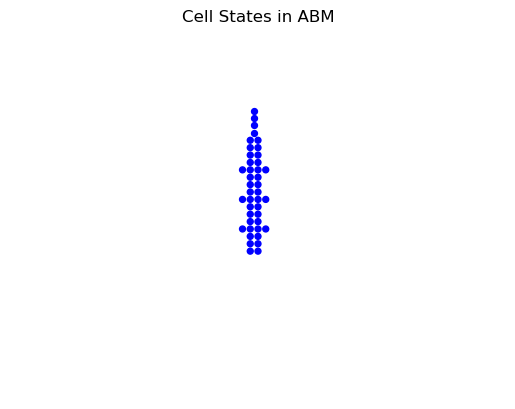

    Positional Information
0                      0.0
1                      0.0
2                      0.0
3                      0.0
4                      0.0
5                      0.0
6                      0.0
7                      0.0
8                      0.0
9                      0.0
10                     0.0
11                     0.0
12                     0.0
13                     0.0
14                     0.0
15                     0.0
16                     0.0
17                     0.0
18                     0.0
19                     0.0


In [354]:
results2 = run_model_with_viz(20, [1,3,14,16])
print(results2)

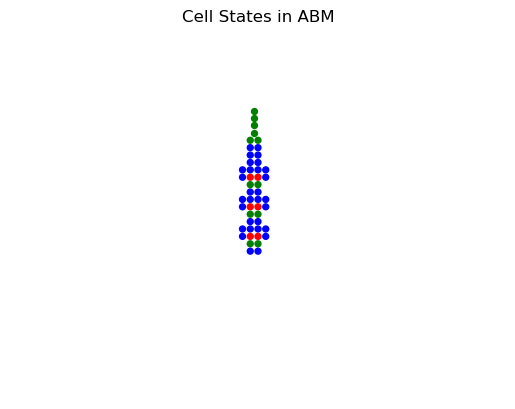

    Positional Information
0                      0.0
1                      0.0
2                      0.0
3                      0.0
4                      0.0
5                      0.0
6                      0.0
7                      0.0
8                      0.0
9                      0.0
10                     1.0
11                     0.0
12                     0.0
13                     0.0
14                     1.0
15                     0.0
16                     0.0
17                     0.0
18                     1.0
19                     0.0


In [376]:
results2 = run_model_with_viz(20, [1,10,11,14])
print(results2)

(32,)


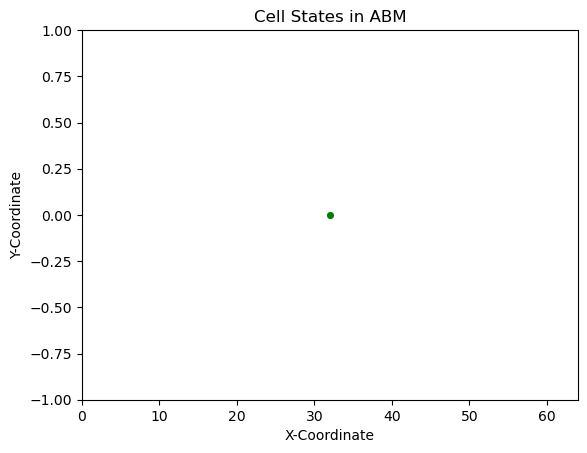

(32,)


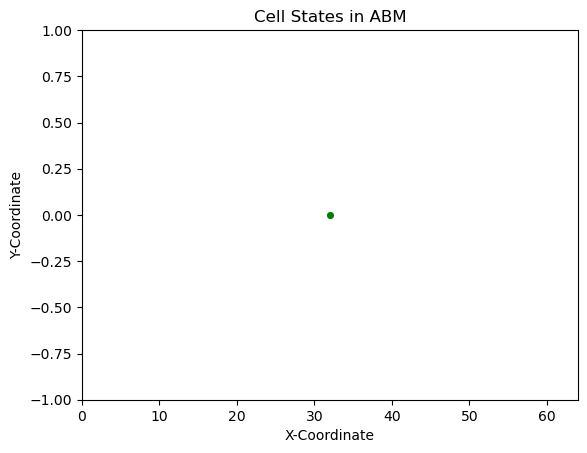

(32,)


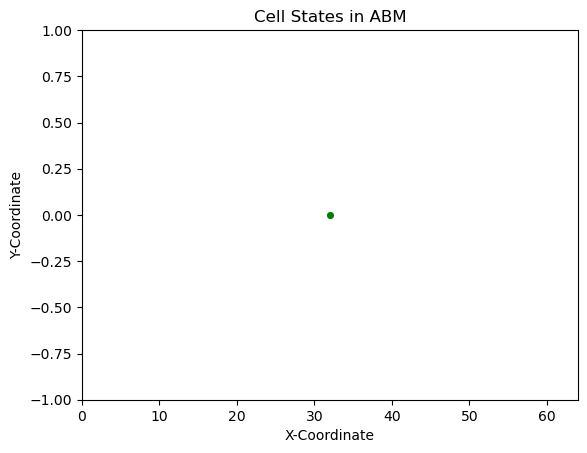

(32,)


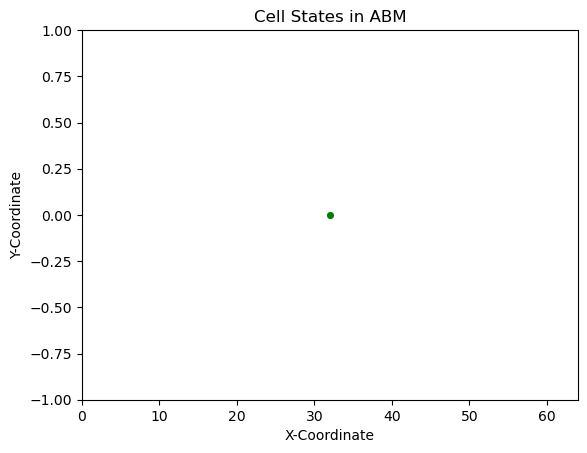

(31, 32)


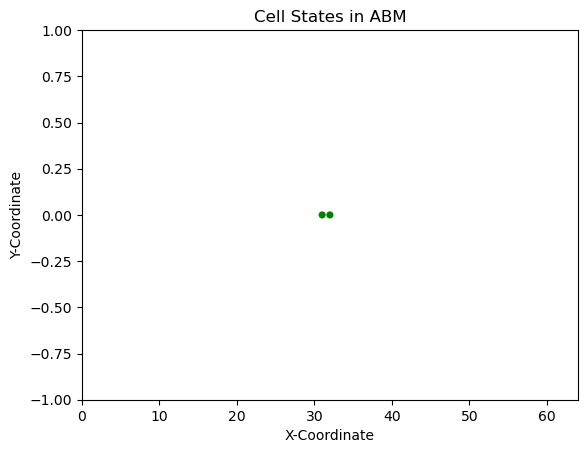

(31, 32)


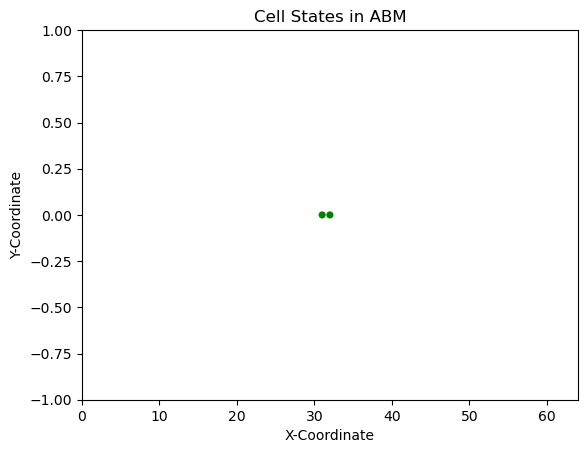

(31, 32)


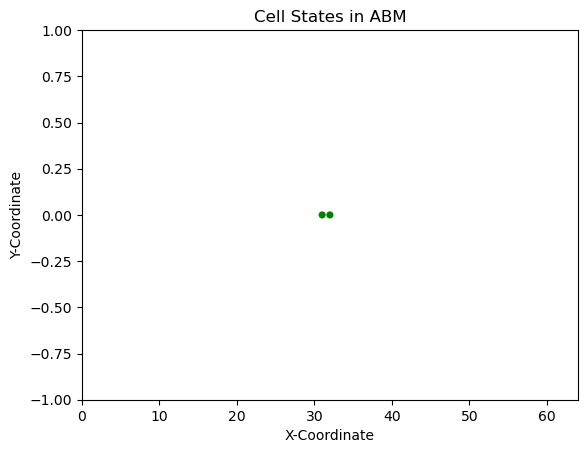

(31, 32)


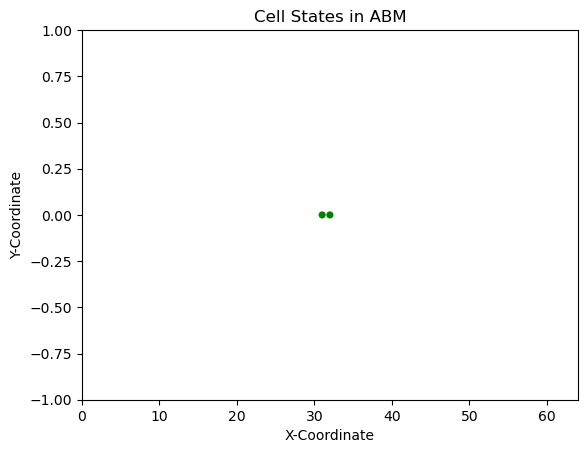

(31, 30, 32, 33)


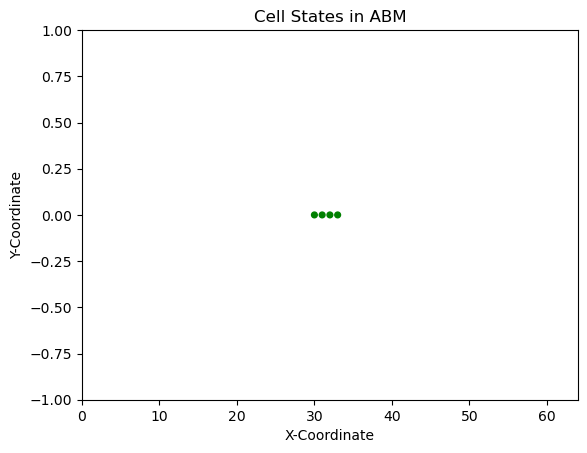

(31, 30, 32, 33)


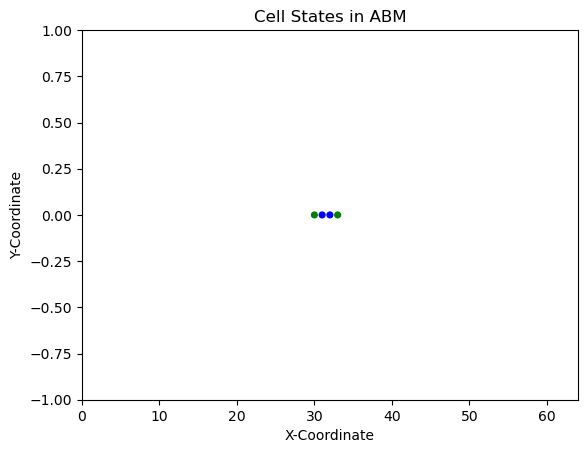

(31, 30, 32, 33)


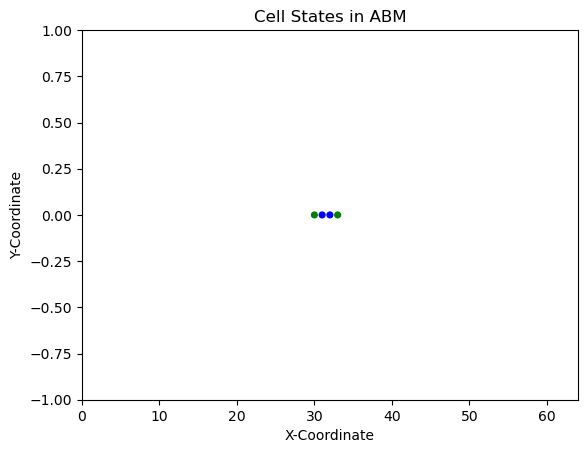

(31, 30, 32, 33)


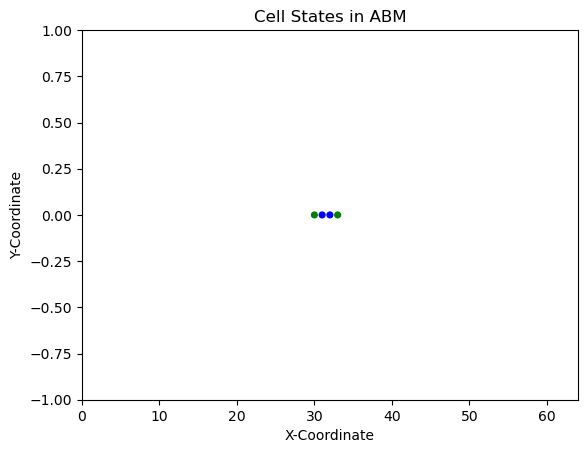

(30, 31, 29, 28, 33, 32, 34, 35)


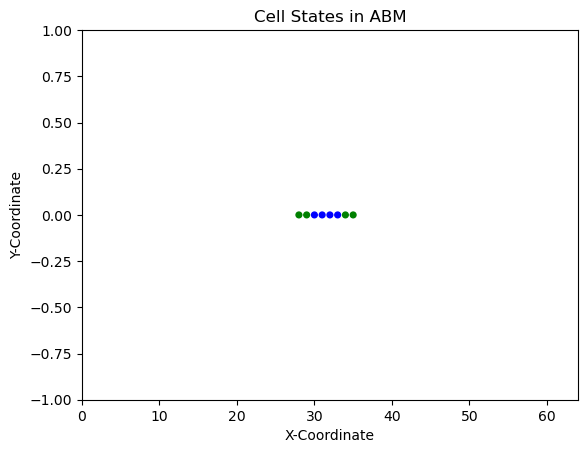

(30, 31, 29, 28, 33, 32, 34, 35)


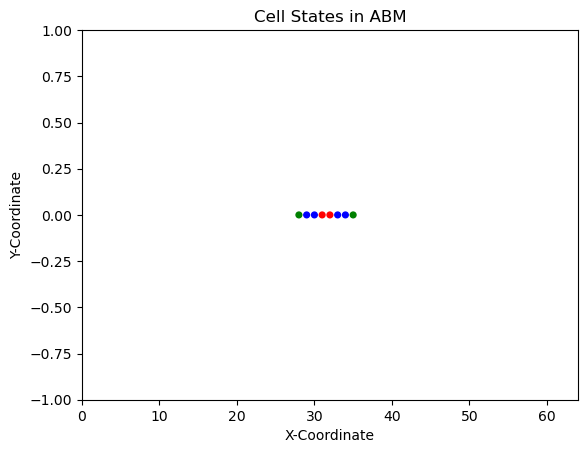

(30, 31, 29, 28, 33, 32, 34, 35)


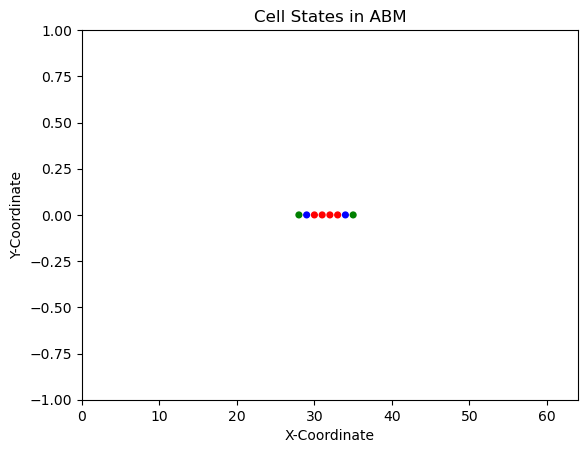

(30, 31, 29, 28, 33, 32, 34, 35)


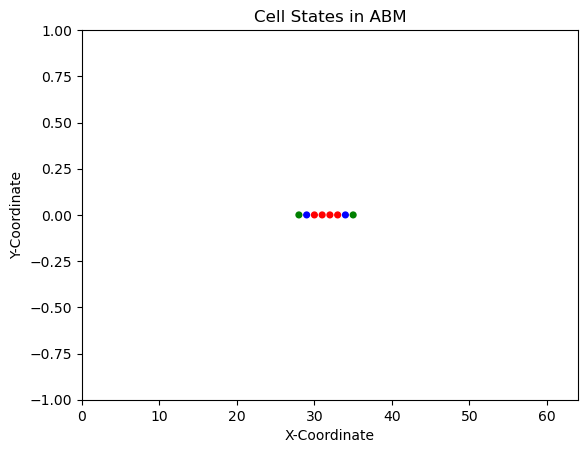

(29, 28, 30, 31, 26, 27, 25, 24, 34, 35, 33, 32, 36, 37, 38, 39)


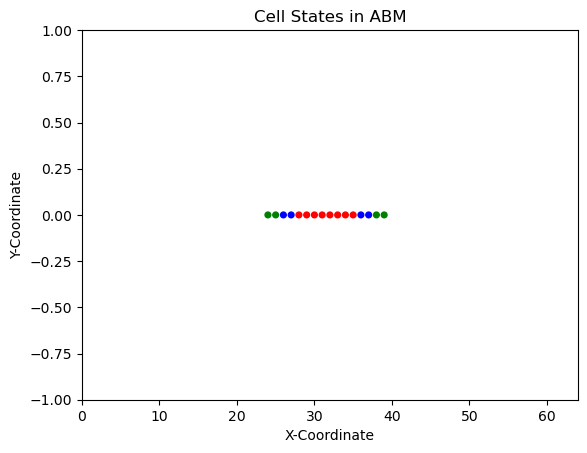

(29, 28, 30, 31, 26, 27, 25, 24, 34, 35, 33, 32, 36, 37, 38, 39)


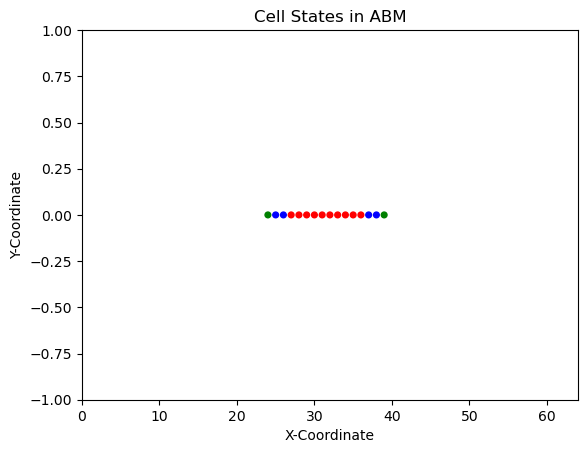

(29, 28, 30, 31, 26, 27, 25, 24, 34, 35, 33, 32, 36, 37, 38, 39)


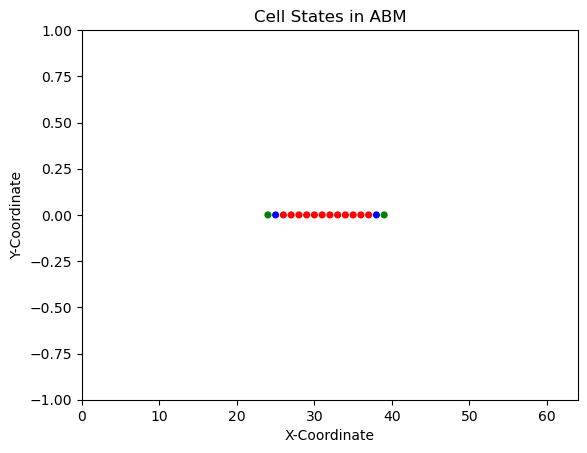

(29, 28, 30, 31, 26, 27, 25, 24, 34, 35, 33, 32, 36, 37, 38, 39)


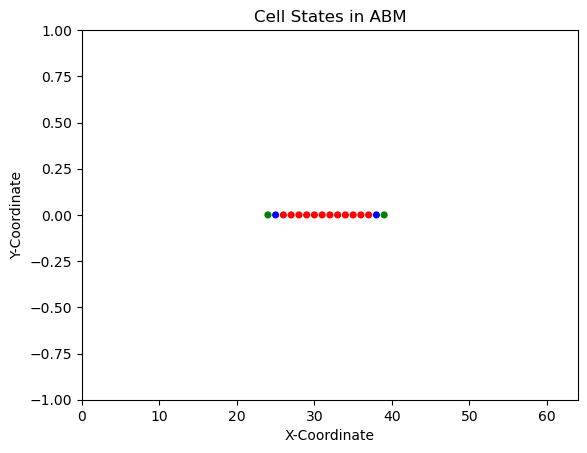

    Positional Information
0                 0.000000
1                 0.000000
2                 0.000000
3                 0.000000
4                 0.000000
5                 0.000000
6                 0.000000
7                 0.000000
8                 0.000000
9                 0.000000
10                1.000000
11                1.000000
12                1.000000
13                1.000000
14                1.500000
15                1.500000
16                1.500000
17                1.500000
18                1.298795
19                1.061278


In [355]:
results3 = run_model_with_viz_every_step(20, [1,4,11,16])
print(results3)